In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import KUL_data as kul
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from model import create_lstm_model, create_conv_lstm_model
kul_metadata_file = '../Data/KUL_Metadata.xlsx'
video_directory = '../Data/KUL'
model_dir = '../model'
fall_file = 'Fall2_Cam4.avi'
adl_file = 'ADL5_Cam4.av'
metadata = kul.get_metadata()
scenarioData: kul.ScenarioData = next((s for s in metadata if s.Scenario == '2'), None)
print("Scenario:", scenarioData)
fall_file_path = next((path for path in scenarioData.get_video_file_paths() if fall_file in path), None)
print("Fall file path:", fall_file_path)

from utils import timestamp

print(timestamp())
tf.__version__


Scenario: ScenarioData(Scenario='2', Start=datetime.time(0, 1, 37), End=datetime.time(0, 1, 40))
Fall file path: ../Data/KUL\Fall2_Cam4.avi
[15:52:00:303]


'2.15.0'

In [2]:
# Number of landmarks
num_landmarks = 33

# Number of frames
num_frames = 45

# Number of coordinates per landmark point
num_coordinates = 2

# Number of seconds beofre the end annotation to include in the training data
capture_window = 2

data_shape = (num_frames, num_landmarks, num_coordinates)
input_shape = (num_frames, num_landmarks * num_coordinates)

print('data shape: ', data_shape)
print('input shape: ', input_shape)

data shape:  (45, 33, 2)
input shape:  (45, 66)


# Load history data

In [3]:
history_dir = '../model'
abs_history_dir = os.path.abspath(history_dir)
print('History dir:', abs_history_dir)

history_suffix = "_history"

def add_model_history_data(filename: str, models_loss: dict, models_accuracy: dict, model_val_loss: dict) -> None:
    if filename.endswith(history_suffix):
        try:
            model_name = filename.split(history_suffix)[0]
            file_path = os.path.join(abs_history_dir, filename)
            print('Load history file:', file_path, '(Size:', os.path.getsize(file_path), 'bytes)')
            with open(file_path, 'rb') as file:
                history = pickle.load(file)
            
            loss_up_to_50 = history['loss'][:50]
            accuracy_up_to_50 = history['accuracy'][:50]
            val_loss_up_to_50 = history['val_loss'][:50]
            
            models_loss[model_name] = loss_up_to_50
            print('Loss at epoch 10:', history['loss'][9])
            models_accuracy[model_name] = accuracy_up_to_50
            print('Accuracy at epoch 10:', history['accuracy'][9])
            model_val_loss[model_name] = val_loss_up_to_50
            print('Validation loss at epoch 10:', history['val_loss'][9])
        except Exception as e:
            print('Error loading history file:', filename, e)

import os
import pickle

history_dir = '../model'
history_suffix = "_history"
cm_suffix = "_50e_cm.npy"

# A model is small, if it has max 100000 parameters
def is_small_model(file_name: str) -> bool:
        model = tf.keras.models.load_model(os.path.join(abs_history_dir, file_name.replace('_history', '_50e.h5')), compile=False)
        return model.count_params() < 100000

def is_variante(file_name: str) -> bool:
    return 'data' in file_name or 'adls' in file_name

all_models_loss = {}
all_models_val_loss = {}
all_models_accuracy = {}
small_models_loss = {}
small_models_val_loss = {}
small_models_accuracy = {}
big_models_loss = {}
big_models_val_loss = {}
big_models_accuracy = {}
varianten_loss = {}
varianten_val_loss = {}
varianten_accuracy = {}

for filename in os.listdir(history_dir):
    if filename.endswith(history_suffix):
        print('Filename:', filename)
        add_model_history_data(filename, all_models_loss, all_models_accuracy, all_models_val_loss)

        if is_small_model(filename):
            add_model_history_data(filename, small_models_loss, small_models_accuracy, small_models_val_loss)
        elif is_variante(filename):
            add_model_history_data(filename, varianten_loss, varianten_accuracy, varianten_val_loss)
        else:
            add_model_history_data(filename, big_models_loss, big_models_accuracy, big_models_val_loss)

print('Small items:', len(small_models_loss))
print('Big items:', len(big_models_loss))
print('Varianten:', len(varianten_loss))
print('All items:', len(all_models_loss))

History dir: c:\Studium\Bachelorarbeit\model
Filename: 1c_8f_1l_10u_history
Load history file: c:\Studium\Bachelorarbeit\model\1c_8f_1l_10u_history (Size: 3676 bytes)
Loss at epoch 10: 0.012987562455236912
Accuracy at epoch 10: 0.9957347512245178
Validation loss at epoch 10: 0.011146570555865765

Load history file: c:\Studium\Bachelorarbeit\model\1c_8f_1l_10u_history (Size: 3676 bytes)
Loss at epoch 10: 0.012987562455236912
Accuracy at epoch 10: 0.9957347512245178
Validation loss at epoch 10: 0.011146570555865765
Filename: 1c_8f_2l_10u_5u_history
Load history file: c:\Studium\Bachelorarbeit\model\1c_8f_2l_10u_5u_history (Size: 3676 bytes)
Loss at epoch 10: 0.011330224573612213
Accuracy at epoch 10: 0.9963944554328918
Validation loss at epoch 10: 0.00942343007773161
Load history file: c:\Studium\Bachelorarbeit\model\1c_8f_2l_10u_5u_history (Size: 3676 bytes)
Loss at epoch 10: 0.011330224573612213
Accuracy at epoch 10: 0.9963944554328918
Validation loss at epoch 10: 0.00942343007773161
F

In [4]:
# Define the LSTM model
simple_model = create_conv_lstm_model(data_shape, 1, [], [1])
conv_lstm_model = create_conv_lstm_model(data_shape, 1, [4], [1])
multi_conv_lstm_model = create_conv_lstm_model(data_shape, 1, [8, 4], [2, 1])
big_model = create_conv_lstm_model(data_shape, 1, [128, 64, 32], [100, 50])

Creating model: 1l_1u
Creating model: 1c_4f_1l_1u
Creating model with [4] filters and [1] units
Creating model: 2c_8f_4f_2l_2u_1u
Creating model with [8, 4] filters and [2, 1] units
Creating model: 3c_128f_64f_32f_2l_100u_50u
Creating model with [128, 64, 32] filters and [100, 50] units


In [5]:

# Compile the models
simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
conv_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
multi_conv_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
big_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the models
simple_model.summary()
conv_lstm_model.summary()
multi_conv_lstm_model.summary()
big_model.summary()

Model: "1l_1u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 45, 66)            0         
                                                                 
 lstm (LSTM)                 (None, 1)                 272       
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 274 (1.07 KB)
Trainable params: 274 (1.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "1c_4f_1l_1u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 45, 33, 2, 1)      0         
                                                                 
 time_dist

: 

In [6]:

# Feed example data to the models
example_sequence = np.random.rand(num_frames, num_landmarks, num_coordinates)
print('example sequence shape: ', example_sequence.shape)
example_data = np.expand_dims(example_sequence, axis=0)
print('example data shape: ', example_data.shape)
example_label = np.random.rand(1, 1)
simple_model.fit(example_data, example_label)
conv_lstm_model.fit(example_data, example_label)
multi_conv_lstm_model.fit(example_data, example_label)

# Run a prediction with the same data for the models
simple_model.predict(example_sequence[np.newaxis, ...])
conv_lstm_model.predict(example_sequence[np.newaxis, ...])
multi_conv_lstm_model.predict(example_sequence[np.newaxis, ...])

example sequence shape:  (45, 33, 2)
example data shape:  (1, 45, 33, 2)


1/1 [==============================] - 1s 599ms/step


array([[0.5017457]], dtype=float32)

In [7]:
# Metadata file has the "end" of fall annotation in column K,
# which is used for labels (fall label starts a second before the end annotation).
# The "start" annotation is in column I, which may be used to guard when readong ADLs from a fall video.
# Fall 1 is in row 3, Fall 2 is in row 4, etc.
# Open kul metadata file
import datetime
import pandas as pd
from KUL_data import ScenarioData
df = pd.read_excel(kul_metadata_file)

# PoC video is Fall2_Cam4.avi, so get the end annotation for Fall 2
end_annotation: datetime.time = df.iloc[2][10]
end_annotation_seconds: int = end_annotation.hour * 3600 + end_annotation.minute * 60 + end_annotation.second
print('End annotation for Fall 2 is', end_annotation)
print('Type of end_annotation is:', type(end_annotation))

start_annotation: datetime.time = df.iloc[2][8]
start_annotation_seconds: int = start_annotation.hour * 3600 + start_annotation.minute * 60 + start_annotation.second
print('Start annotation for Fall 2 is', start_annotation)
print('Type of start_annotation is:', type(start_annotation))

# Label for fall detection starts a second before the end annotation (make it contain just the time part)
fall_label_start = datetime.datetime.combine(datetime.date.today(), end_annotation) - datetime.timedelta(seconds=capture_window)
fall_label_start = fall_label_start.time()
print('Fall label starts at', fall_label_start)
scenario2: ScenarioData = ScenarioData('2', start_annotation, end_annotation)

End annotation for Fall 2 is 00:01:40
Type of end_annotation is: <class 'datetime.time'>
Start annotation for Fall 2 is 00:01:37
Type of start_annotation is: <class 'datetime.time'>
Fall label starts at 00:01:38


In [8]:
video_directory = '../Data/KUL'
fall_file = 'Fall2_Cam4.avi'
adl_file = 'ADL5_Cam4.avi'

# Make sure the video files exist
fall_file_path = os.path.join(video_directory, fall_file)
adl_file_path = os.path.join(video_directory, adl_file)
if not os.path.isfile(fall_file_path):
    print('Error: File', fall_file_path, 'does not exist')
    exit(1)
if not os.path.isfile(adl_file_path):
    print('Error: File', adl_file_path, 'does not exist')
    exit(1)

In [9]:
from video_processor import VideoProcessor

video_processor = VideoProcessor(num_frames, capture_window)

In [9]:
import cv2

video_path = os.path.join(video_directory, fall_file)
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print(f"Error: Failed to open video file {video_path}")
    exit(1)

# Get the frames per second (FPS) of the video
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"FPS of the video: {fps}")

# Release the video capture object
cap.release()

FPS of the video: 30.0


# Load data

In [10]:
import os

fall_data = video_processor.load_sequences(os.path.join(video_directory, fall_file))
adl_data = video_processor.load_sequences(os.path.join(video_directory, adl_file))
fall_adl_data = video_processor.load_sequences(os.path.join(video_directory, fall_file), "_adls")

# Make sure data isn't empty
if len(fall_data) == 0:
    print('Error: No fall data found')
    exit(1)
if len(adl_data) == 0:
    print('Error: No adl data found')
    exit(1)
if len(fall_adl_data) == 0:
    print('Error: No fall adl data found')
    exit(1)

In [11]:
def print_sequences(sequences):
    print('Shape of data:', sequences.shape)
    print('Number of sequences:', len(sequences))
    print('Number of poses in first sequence:', len(sequences[0]))
    print('Number of landmarks in first pose:', len(sequences[0][0]))
    print('Coordinates of first landmark in first pose:', sequences[0][0][0])

In [12]:
print('Fall data:')
print_sequences(fall_data)

print('ADL data:')
print_sequences(adl_data)

print('Fall ADL data:')
print_sequences(fall_adl_data)

Fall data:
Shape of data: (30, 45, 33, 3)
Number of sequences: 30
Number of poses in first sequence: 45
Number of landmarks in first pose: 33
Coordinates of first landmark in first pose: [0.45667511 0.3188458  0.1899023 ]
ADL data:
Shape of data: (121, 45, 33, 3)
Number of sequences: 121
Number of poses in first sequence: 45
Number of landmarks in first pose: 33
Coordinates of first landmark in first pose: [0.49101336 0.12086327 0.24768784]
Fall ADL data:
Shape of data: (166, 45, 33, 3)
Number of sequences: 166
Number of poses in first sequence: 45
Number of landmarks in first pose: 33
Coordinates of first landmark in first pose: [0.548362   0.4987898  0.68277495]


# Test random shifting

In [13]:
import numpy as np
from utils import draw_pose_on_image, draw_sequence_on_image, draw_key_poses_on_image, shade_color

def random_shift(sequence: np.ndarray) -> np.ndarray:
    # The sequence might have 2 or 3 coordinates - just lose the last one if it's there
    sequence = sequence[:, :, :2]
    # Calculate the min and max values for x and y dimensions
    min_values = np.min(sequence, axis=(0, 1))
    max_values = np.max(sequence, axis=(0, 1))

    # Calculate the maximum shift in each direction (max shift is until the edge of the frame)
    max_shifts = np.minimum(min_values, 1 - max_values)

    # Generate a random shift within the allowable range
    shifts = (np.random.rand(2) - 0.5) * 2 * max_shifts


    # Apply the shift to the entire sequence
    shifted_sequence = sequence + shifts

    return shifted_sequence

# Draw three key poses on a blank image one after another
def draw_key_poses_on_separate_images(sequence, color=(255, 255, 255)):
    images = []
    img_size = (480, 640, 3)  # Assuming each image has this size

    # Check if there are poses to draw
    if len(sequence) > 0:
        # Create and draw on the first image
        img1 = np.full(img_size, 255, dtype=np.uint8)
        img1 = draw_pose_on_image(img1, sequence[0], shade_color(color, 0.8))
        images.append(img1[120:360, 160:480])

        # Create and draw on the second image
        img2 = np.full(img_size, 255, dtype=np.uint8)
        second_pose_index = -(len(sequence) // 8)
        img2 = draw_pose_on_image(img2, sequence[second_pose_index], shade_color(color, 0.6))
        images.append(img2[120:360, 160:480])

        # Create and draw on the third image
        img3 = np.full(img_size, 255, dtype=np.uint8)
        img3 = draw_pose_on_image(img3, sequence[-1], shade_color(color, 0.0))
        images.append(img3[120:360, 160:480])

    # return concatted images
    return np.concatenate(images, axis=1)

First fall sequence:


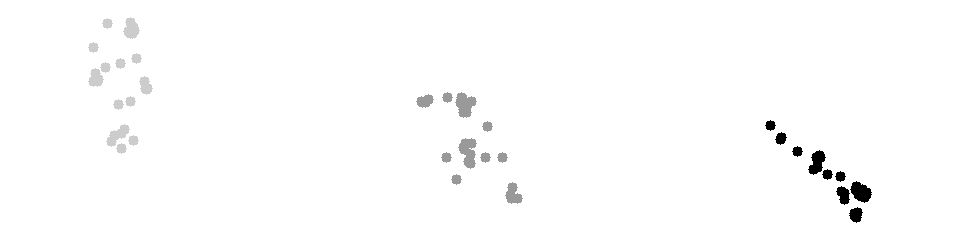

Manual sequence:


FileNotFoundError: [Errno 2] No such file or directory: 'PoseEstimation\\seq.npy'

In [14]:
from PIL import Image as Img
# Visualize the first sequence
first_fall_sequence = fall_data[0]
print('First fall sequence:')
img = draw_key_poses_on_separate_images(first_fall_sequence)
# cut 25% from each side of the image
#img = img[120:360, 160:480]
display(Img.fromarray(img.astype(np.uint8)))

print('Manual sequence:')
seq = np.load(os.path.join("PoseEstimation", "seq.npy"))
print('Shape:', seq.shape)
x_range = [np.min(seq[:, :, 0]), np.max(seq[:, :, 0])]
y_range = [np.min(seq[:, :, 1]), np.max(seq[:, :, 1])]
print('X range:', x_range)
print('Y range:', y_range)
img = draw_key_poses_on_separate_images(seq)
display(Img.fromarray(img.astype(np.uint8)))

In [ ]:
# Visualize the first sequence after a random shift
shifted_sequence = random_shift(first_fall_sequence)
print('Shifted sequence:')
img = draw_sequence_on_image(np.full((480, 640, 3), 255), shifted_sequence, color=(0, 0, 0))
# add tiny border to the image
img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=(200, 200, 200))
display(Img.fromarray(img.astype(np.uint8)))

Shifted sequence:


In [ ]:
# Save a single sequence to a file
import os
print('Sequence type:', type(first_fall_sequence))
print('Sequence shape:', first_fall_sequence.shape)
first_fall_sequence_path = 'first_fall_sequence.npy'
os.remove(first_fall_sequence_path) if os.path.exists(first_fall_sequence_path) else None
poseviz_data = first_fall_sequence.reshape(-1, 33, 3)
print('poseviz_data shape:', poseviz_data.shape)
np.save(first_fall_sequence_path, poseviz_data)

# Annotated sequence

In [ ]:
import numpy as np
from utils import draw_pose_on_image, draw_sequence_on_image, draw_key_poses_on_image, convert_to_positive_indices
import os, sys
import cv2
from PIL import Image as Img

num_frames = 45

# Make sure folders exist
save_dir = "PoseEstimation/last_sequence_annotated"
if not os.path.exists(save_dir):
    raise Exception(f"Directory {save_dir} does not exist")
orig_dir = os.path.join(save_dir, "original_images")
overlayed_poses_dir = os.path.join(save_dir, "overlayed_poses")
overlayed_coordinates_dir = os.path.join(save_dir, "overlayed_coordinates")
poses_dir = os.path.join(save_dir, "poses")
seq_path = os.path.join("PoseEstimation", "seq.npy")
if not os.path.exists(orig_dir):
    raise Exception(f"Directory {orig_dir} does not exist")
if not os.path.exists(overlayed_poses_dir):
    raise Exception(f"Directory {overlayed_poses_dir} does not exist")
if not os.path.exists(overlayed_coordinates_dir):
    raise Exception(f"Directory {overlayed_coordinates_dir} does not exist")
if not os.path.exists(poses_dir):
    raise Exception(f"Directory {poses_dir} does not exist")
if not os.path.exists(seq_path):
    raise Exception(f"File {seq_path} does not exist")

# Make sure each folder has 45 files
orig_files = os.listdir(orig_dir)
overlayed_poses_files = os.listdir(overlayed_poses_dir)
overlayed_coordinates_files = os.listdir(overlayed_coordinates_dir)
poses_files = os.listdir(poses_dir)
if len(orig_files) != num_frames:
    raise Exception(f"Directory {orig_dir} does not have {num_frames} files")
if len(overlayed_poses_files) != num_frames:
    raise Exception(f"Directory {overlayed_poses_dir} does not have {num_frames} files")
if len(overlayed_coordinates_files) != num_frames:
    raise Exception(f"Directory {overlayed_coordinates_dir} does not have {num_frames} files")
if len(poses_files) != num_frames:
    raise Exception(f"Directory {poses_dir} does not have {num_frames} files")

# Make sure sequence has 45 frames
seq = np.load(seq_path)
if seq.shape[0] != num_frames:
    raise Exception(f"Sequence does not have {num_frames} frames")

# Key frames: 0, -len//8, -1
key_frames = [0, -len(seq)//4, -1]
key_indices = convert_to_positive_indices(seq, key_frames)
print('Key frames:', key_frames)
print('Key indices:', key_indices)

def file(num: int):
    return f"{num}.png"

def orig(num: int):
    return os.path.join(orig_dir, file(num))

def overlayed_pose(num: int):
    return os.path.join(overlayed_poses_dir, file(num))

def overlayed_coordinates(num: int):
    return os.path.join(overlayed_coordinates_dir, file(num))

def pose(num: int):
    return os.path.join(poses_dir, file(num))

# Display original key frames side by side
cut_left = 0.2
cut_top = 0.25
cut_right = 0.4
original_images = []
for i in key_indices:
    img = cv2.imread(orig(i))
    height, width, _ = img.shape
    img = img[int(height*cut_top):, int(width*cut_left):int(width*(1-cut_right))]
    original_images.append(img)
print("Original key frames")
display(Img.fromarray(np.concatenate(original_images, axis=1)))

# Then display overlayed poses
overlayed_pose_images = []
for i in key_indices:
    img = cv2.imread(overlayed_pose(i))
    height, width, _ = img.shape
    img = img[int(height*cut_top):, int(width*cut_left):int(width*(1-cut_right))]
    overlayed_pose_images.append(img)
print("Overlayed poses")
display(Img.fromarray(np.concatenate(overlayed_pose_images, axis=1)))

# Then display overlayed coordinates
overlayed_coordinate_images = []
for i in key_indices:
    img = cv2.imread(overlayed_coordinates(i))
    height, width, _ = img.shape
    img = img[int(height*cut_top):, int(width*cut_left):int(width*(1-cut_right))]
    overlayed_coordinate_images.append(img)
print("Overlayed coordinates")
display(Img.fromarray(np.concatenate(overlayed_coordinate_images, axis=1)))

# Then display poses
pose_images = []
for i in key_indices:
    img = cv2.imread(pose(i))
    height, width, _ = img.shape
    img = img[int(height*cut_top):, int(width*cut_left):int(width*(1-cut_right))]
    pose_images.append(img)
print("Poses")
display(Img.fromarray(np.concatenate(pose_images, axis=1)))

# To Thesis/img/vorverarbeitung/orig|overlayed_poses|overlayed_coordinates|poses/{num}.png
results_dir = "../Thesis/img/vorverarbeitung"
orig_dir = os.path.join(results_dir, "orig")
overlayed_poses_dir = os.path.join(results_dir, "overlayed_poses")
overlayed_coordinates_dir = os.path.join(results_dir, "overlayed_coordinates")
poses_dir = os.path.join(results_dir, "poses")
os.makedirs(orig_dir, exist_ok=True)
os.makedirs(overlayed_poses_dir, exist_ok=True)
os.makedirs(overlayed_coordinates_dir, exist_ok=True)
os.makedirs(poses_dir, exist_ok=True)

# Save the images
for i in range(len(key_indices)):
    cv2.imwrite(os.path.join(orig_dir, file(i)), original_images[i])
    cv2.imwrite(os.path.join(overlayed_poses_dir, file(i)), overlayed_pose_images[i])
    cv2.imwrite(os.path.join(overlayed_coordinates_dir, file(i)), overlayed_coordinate_images[i])
    cv2.imwrite(os.path.join(poses_dir, file(i)), pose_images[i])

# Poseviz

In [ ]:
# Convert to poseviz
import numpy as np
import time
import uuid
import os
import datetime

def print_vec(vector):
    return ' '.join(map(lambda c: "%0.5f" % c, vector))     # "%0.5f" % c -> rundet auf 5 Nachkommastellen


class PoseVizWriter:
    
    def __init__(self, filename: str, ms_per_frame: int, is_mediapipe=True):
        self.file = open(filename, "w")
        self.frame_num: int = 0
        self.ms_per_frame: int = ms_per_frame
        self.is_mediapipe = is_mediapipe

        start_time = datetime.datetime.utcnow()
        self.file.write(f'# PoseViz Tracking Data - Schema 0.4\n')
        self.file.write('################################################################\n')
        self.file.write(f'# title: {filename.split("/")[-1]}\n')
        self.file.write('# owner: Marlon Regenhardt\n')
        self.file.write(f'# date: {start_time.isoformat()[:10]}\n')
        self.file.write(f'# id: {str(uuid.uuid4())}\n')
        self.file.write('################################################################\n')

        self.file.write('# --- object detection initialization parameters\n')
        if is_mediapipe:
            self.file.write('# detection backend: MediaPipe Pose\n')

        self.file.write('################################################################\n')
        self.file.write(f'ts {start_time.isoformat()[:23]}\n')
        # Camera Position ist nicht Akkurat aber hilfreich
        self.file.write('ct 0 -0.5 -2\n')
        self.file.write('co 0 0 0 1\n')

    def __enter__(self):
        return self

    def write_frame(self, keypoints: np.ndarray, label=None):
        if self.is_mediapipe and keypoints.shape != (33, 3):
            raise TypeError("Frame is not Mediapipe conform and would create a corrupted file")
        frame_string = f"f {self.frame_num}\n"
        self.frame_num += self.ms_per_frame
        frame_string += f"p 0 {print_vec(keypoints[0])}\n"
        if label is not None:
            frame_string += f"m {label}\n"
        for kp_id, kp in enumerate(keypoints):
            frame_string += f"k {kp_id} {print_vec(kp)}\n"
        self.file.write(frame_string)

    def write_empty_frame(self):
        frame_string = f"f {self.frame_num}\n"
        self.frame_num += self.ms_per_frame
        self.file.write(frame_string)

    def close(self):
        if not self.file.closed:
            self.file.close()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()

def create_poseviz_file(data: np.ndarray, filename: str):
    fps = 16
    with PoseVizWriter(filename, 1000//fps) as writer:
        for frame in data:
            writer.write_frame(frame)


# Usage
#data = np.array(fall_data[10])  # Shape: (45, 33, 3)
data = np.load(os.path.join("PoseEstimation", "seq.npy"), allow_pickle=True)
print('Data shape:', data.shape)
create_poseviz_file(data, "output.pose")


# Test video processing

In [ ]:
import os

print(timestamp(), 'Processing fall file', fall_file)
start_time = datetime.datetime.now()
fall_data_file = video_processor.process_fall(os.path.join(video_directory, fall_file), end_annotation_seconds)
print(timestamp(), 'Time to process fall file:', datetime.datetime.now() - start_time)
start_time = datetime.datetime.now()
print(timestamp(), 'Processing adl file', adl_file)
adl_data_file = video_processor.process_adls(os.path.join(video_directory, adl_file))
print(timestamp(), 'Time to process adl file:', datetime.datetime.now() - start_time)
start_time = datetime.datetime.now()
print(timestamp(), 'Reading ADLs from fall file', fall_file)
fall_adls = video_processor.process_adls_from_fall_video(os.path.join(video_directory, fall_file), start_annotation_seconds, end_annotation_seconds)
print(timestamp(), 'Time to read ADLs from fall file:', datetime.datetime.now() - start_time)

# Test the Preprocessor

In [ ]:
import preprocessor

preprocessed_fall_file, preprocessed_adl_file = preprocessor.preprocess_fall_video(os.path.join(video_directory, fall_file), start_annotation, end_annotation)
preprocessed_fall_data = video_processor.load_sequences(preprocessed_fall_file)
print('Preprocessed fall data:')
print_sequences(preprocessed_fall_data)
shifted_data = np.array([preprocessor.random_shift(sequence) for sequence in preprocessed_fall_data])
print('Shifted data:')
print_sequences(shifted_data)
augmented_fall_data, fall2_adl_data = preprocessor.preprocess_scenario(scenario2, random_shift_fall_data=0)
print('Augmented fall data:')
print_sequences(augmented_fall_data)

# Simple training

In [ ]:
# For training, batch each fall sequence with an ADL sequence
# Start from the top of the sorted ADL sequences, and take until the number of ADL sequences is equal to the number of fall sequences

# ADL sequences for use with training etc.
adl_pool = adl_data[:len(fall_data)][:, :, :, :2]

## Concat fall_adfall_adl_datals to the adl pool
adl_pool = np.concatenate((adl_pool, fall_adl_data))

# fall sequences for use with training etc.
fall_pool = fall_data[:, :, :, :2]

# Split both fall and ADL sequences into training and validation sets
from sklearn.model_selection import train_test_split

fall_train, fall_val = train_test_split(fall_pool, test_size=0.2)
adl_train, adl_val = train_test_split(adl_pool, test_size=0.2)

# Create the training and validation data
X_train = np.concatenate((fall_train, adl_train))
X_val = np.concatenate((fall_val, adl_val))

# Create the labels for the training and validation data
y_train = np.concatenate((np.ones(len(fall_train)), np.zeros(len(adl_train))))
y_val = np.concatenate((np.ones(len(fall_val)), np.zeros(len(adl_val))))

# Shuffle the training data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

# Fit the models
simple_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
conv_lstm_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
multi_conv_lstm_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

In [ ]:

# Show score on validation set
eval_simple = simple_model.evaluate(X_val, y_val)
eval_conv_lstm = conv_lstm_model.evaluate(X_val, y_val)
eval_multi = multi_conv_lstm_model.evaluate(X_val, y_val)

print('Simple model validation loss:', eval_simple[0])
print('Simple model validation accuracy:', eval_simple[1])
print('Conv LSTM model validation loss:', eval_conv_lstm[0])
print('Conv LSTM model validation accuracy:', eval_conv_lstm[1])
print('Multi Conv LSTM model validation loss:', eval_multi[0])
print('Multi Conv LSTM model validation accuracy:', eval_multi[1])

In [5]:
model_dir = '../model'
model_file = 'simple_model.keras'

In [ ]:
# Save the model
simple_model.save(os.path.join(model_dir, model_file))

# Structure test

In [9]:
from model import create_lstm_model, create_conv_lstm_model
class TestParams:
    def __init__(self):
        self.units_list = [100, 10]
        self.filters_list = [32, 16, 8]

test_params = TestParams()
testmodel = create_conv_lstm_model(data_shape, 1, test_params.filters_list, test_params.units_list, None)
print('Configured input shape:', data_shape)
testmodel.summary()

Creating model: 3c_32f_16f_8f_2l_100u_10u
Creating model with [32, 16, 8] filters and [100, 10] units
Configured input shape: (45, 33, 2)
Model: "3c_32f_16f_8f_2l_100u_10u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 45, 33, 2, 1)      0         
                                                                 
 time_distributed_4 (TimeDi  (None, 45, 33, 2, 32)     320       
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 45, 33, 2, 16)     4624      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 45, 33, 2, 8)      1160      
 stributed)                                                      
                                   

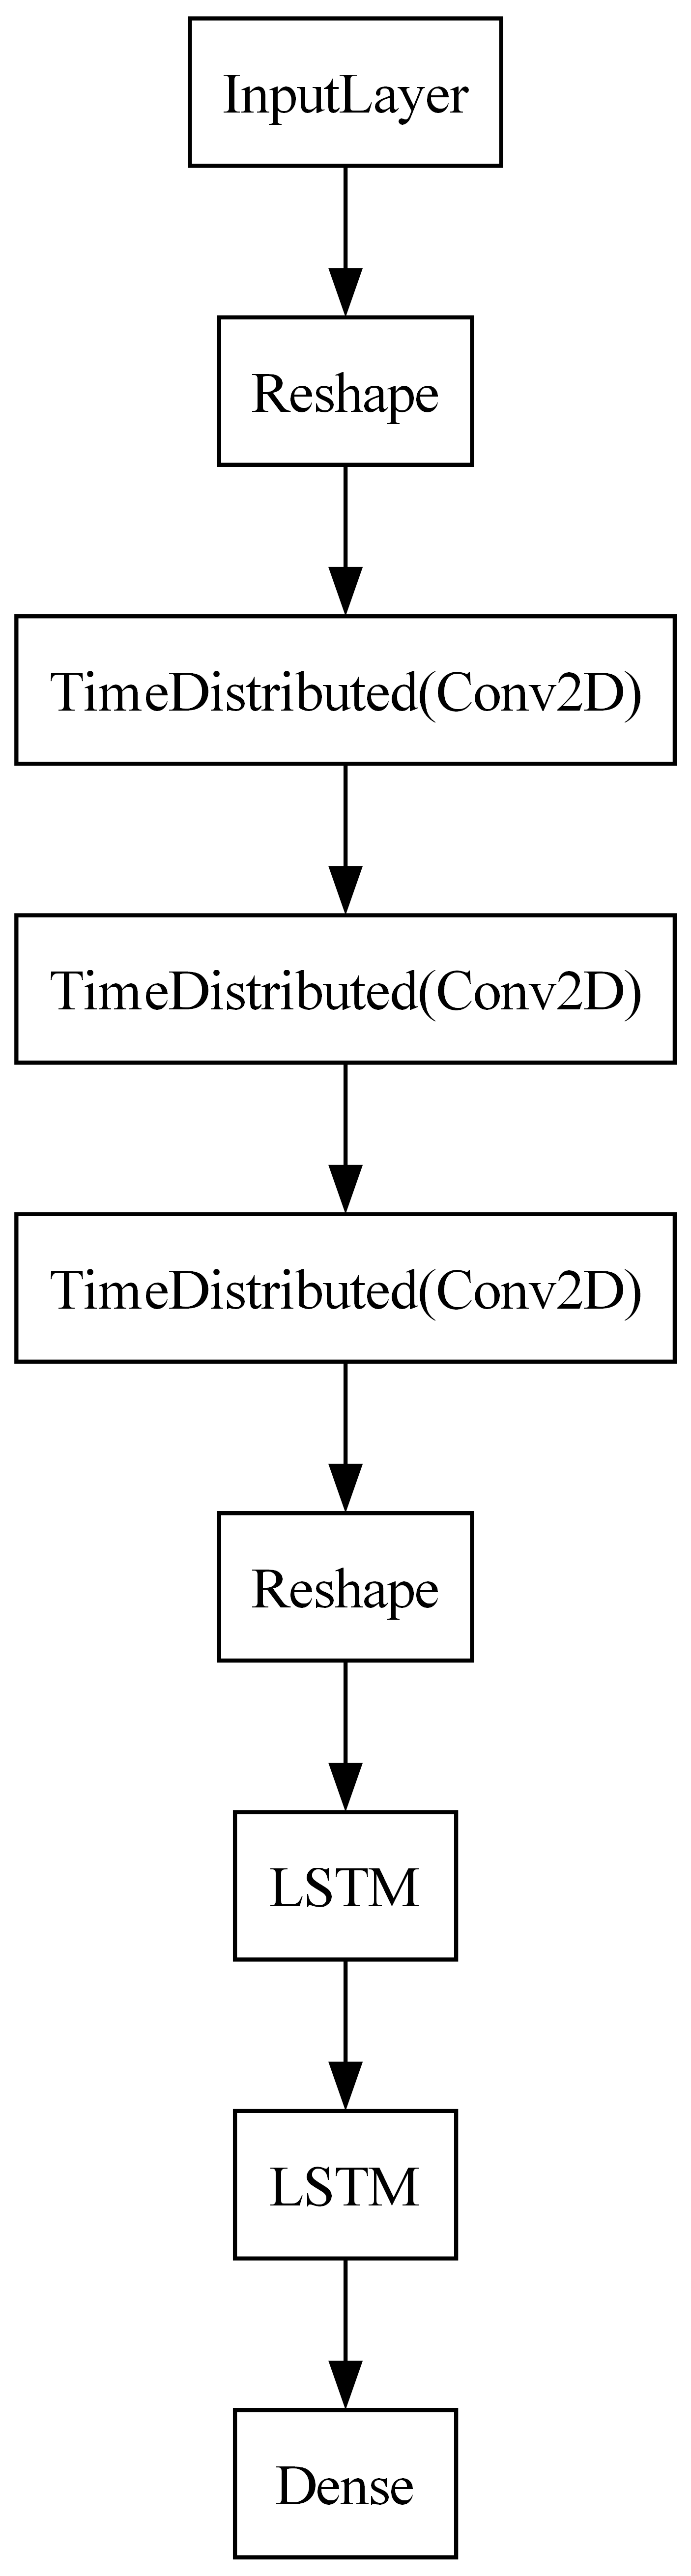

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(testmodel, to_file='..\Thesis\img\model.png', show_shapes=False, show_layer_names=False, rankdir='TD', dpi=600)

# Model demonstration

In [6]:
import tensorflow as tf
import os

model_dir = '../model'
model_name = '3c_128f_64f_32f_2l_100u_50u_without_implicit_adls.h5'
model = tf.keras.models.load_model(os.path.join(model_dir, model_name))
model.summary()

# Print the input shape the model expects
print('Input shape:', model.input_shape)
print('Model name:', model.name)

OSError: No file or directory found at ../model\3c_128f_64f_32f_2l_100u_50u_without_implicit_adls.h5

In [24]:
from PoseEstimation.pose_processor import PoseProcessor
import cv2
import numpy as np
import tensorflow as tf

# Global variable to store the coordinates of the last mouse click
mouse_click_coords = None

# Mouse callback function to record the coordinates of the mouse click
def mouse_callback(event, x, y, flags, param):
    global mouse_click_coords
    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_click_coords = (x, y)

# model = tf.keras.models.load_model(os.path.join(model_dir, "3c_128f_64f_32f_2l_100u_50u_without_implicit_adls.h5"))
def run_model_on_cap(model, cap, num_frames=45, skip_frames=1):
    global mouse_click_coords
    print('Running model on video')
    model.summary()
    pose_processor = PoseProcessor(frames=num_frames, skip_frames=skip_frames)

    paused = False  # Flag to indicate if the video is paused or not
    # Timestamp to keep track of the time elapsed since the last frame was processed and add an fps counter to the image
    prev_time = cv2.getTickCount()
    
    # Set the mouse callback for the window
    cv2.namedWindow('Model runner')
    cv2.setMouseCallback('Model runner', mouse_callback)
    
    while True:
        if not paused:
            ret, img = cap.read()
            if not ret:
                break

            # Image has black bars on the sides, so crop them out
            img = img[:, 80:720]
            # First, process the image and get the current pose sequence
            seq = pose_processor.process_and_get_current_sequence(img)

            # Then run the model on the sequence
            if seq is not None:
                if seq.shape[2] == 3:
                    seq = seq[:, :, :2]
                #print('seq shape:', seq.shape)
                prediction = model.predict(seq[np.newaxis, ...])[0][0] > 0.9
            else:
                prediction = "-"
            
            curr_time = cv2.getTickCount()
            fps = cv2.getTickFrequency() / (curr_time - prev_time)
            prev_time = curr_time
            #cv2.putText(img, f"FPS: {int(fps)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(img, f"Fall: {prediction}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Check if there was a mouse click and display the coordinates
            if mouse_click_coords is not None:
                x, y = mouse_click_coords
                cv2.putText(img, f"Clicked: ({x}, {y})", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow('Model runner', img)
            key = cv2.waitKey(1) & 0xFF  # Short wait time when video is playing
        else:
            key = cv2.waitKey(100) & 0xFF  # Longer wait time when video is paused

        if key == ord('q'):
            break
        elif key == 32:  # ASCII for spacebar
            paused = not paused  # Toggle the paused state

try:
    run_model_on_cap(model, cv2.VideoCapture(os.path.join(video_directory, fall_file)))
    cv2.destroyAllWindows()
except:
    cv2.destroyAllWindows()
    raise

Running model on video
Model: "3c_128f_64f_32f_2l_100u_50u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 45, 33, 2, 1)      0         
                                                                 
 time_distributed_3 (TimeDi  (None, 45, 33, 2, 128)    1280      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 45, 33, 2, 64)     73792     
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 45, 33, 2, 32)     18464     
 stributed)                                                      
                                                                 
 reshape_3 (Reshape)         (None, 45, 2112)          0         
                

# To ONNX

In [ ]:
import tensorflow as tf
import tf2onnx
import os

onnx_model_name = model_name.replace('.h5', '.onnx')
onnx_model_path = os.path.join(model_dir, onnx_model_name)
if not os.path.exists(onnx_model_path):
    # Load your Keras model
    keras_model = tf.keras.models.load_model(os.path.join(model_dir, model_name))

    # Convert the Keras model to ONNX
    onnx_model, _ = tf2onnx.convert.from_keras(keras_model)

    # Save the ONNX model
    with open(onnx_model_path, "wb") as f:
        f.write(onnx_model.SerializeToString())

# TVM

In [ ]:
from tvm.driver import tvmc
absolute_path = os.path.abspath(model_dir)
tvmc_model = tvmc.load(os.path.join(absolute_path, onnx_model_name))
#tvmc_model.summary()
tvmc.tune(tvmc_model, target="llvm")
#package = tvmc.compile(tvmc_model, target="llvm")

# Inferenzzeit messen

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from PoseEstimation.pose_processor import PoseProcessor
import datetime
import time

def measure_inference_time(model_path: str, video_path: str) -> tuple:
    print(timestamp(), f"Measuring inference time for model {model_path} on video {video_path}")
    measurement_start = time.time()
    # Load the model
    model = tf.keras.models.load_model(model_path, compile=False)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception(f"Error: Failed to open video file {video_path}")
    
    pose_processor = PoseProcessor(frames=num_frames, skip_frames=1)
    inference_times = []
    mediapipe_times = []
    
    while True:
        ret, frame = cap.read()
        if not ret or len(inference_times) >= 1000:
            break
        
        # Process the frame to get the pose sequence
        start_mediapipe = time.time()
        sequence = pose_processor.process_and_get_current_sequence(frame)
        end_mediapipe = time.time()
        mediapipe_times.append(end_mediapipe - start_mediapipe)
        
        # Inference whenever MediaPipe detencts a person
        if sequence is not None:
            if sequence.shape[2] == 3:
                sequence = sequence[:, :, :2]
            
            # Measure inference time
            start_inference = time.time()
            model.predict(sequence[np.newaxis, ...], verbose=0)
            end_inference = time.time()
            
            inference_times.append(end_inference - start_inference)
    
    cap.release()
    
    if not inference_times:
        raise Exception("No valid sequences found in the given time range.")
    
    # Calculate the average inference time
    avg_inference_time = sum(inference_times) / len(inference_times)
    avg_mediapipe_time = sum(mediapipe_times) / len(mediapipe_times)

    measurement_end = time.time()
    measurement_time = measurement_end - measurement_start
    return avg_inference_time, avg_mediapipe_time, len(inference_times), measurement_time

# Example usage with smallest model
abs_path = os.path.abspath(model_dir)
model_name = '1c_8f_1l_10u_50e.h5'
model_path = os.path.join(abs_path, model_name)
print("pwd:", os.getcwd())
print("model_dir:", model_dir)
print("abs_path:", abs_path)
print("model_path:", model_path)
model_inference_time, mediapipe_inference_time, data_points, measurement_time = measure_inference_time(model_path, fall_file_path)
time_ms = round(model_inference_time * 1000)
mediapipe_time_ms = round(mediapipe_inference_time * 1000)
print(f"Average inference times over {data_points} measurements:")
print(f"Model: {time_ms}ms")
print(f"MediaPipe: {mediapipe_time_ms}ms")
print(f"Measurement time: {round(measurement_time, 2)}s")

pwd: c:\Studium\Bachelorarbeit\Code
model_dir: ../model
abs_path: c:\Studium\Bachelorarbeit\model
model_path: c:\Studium\Bachelorarbeit\model\1c_8f_1l_10u_50e.h5
[17:21:31:621] Measuring inference time for model c:\Studium\Bachelorarbeit\model\1c_8f_1l_10u_50e.h5 on video ../Data/KUL\Fall2_Cam4.avi


C:\Users\mregenhardt\AppData\Roaming\Python\Python311\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Average inference times over 1000 measurements:
Model: 50ms
MediaPipe: 12ms
Measurement time: 74.94s


In [16]:
from utils import InferenceTime, print_inference_time

def get_model_size(model_path: str) -> int:
    model = tf.keras.models.load_model(model_path, compile=False)
    params = model.count_params()
    memory_footprint = params * 4 / 1024 / 1024  # 4 bytes per float32
    return memory_footprint, params
    
# Example:
inference_time = InferenceTime(model_inference_time, mediapipe_inference_time, data_points, measurement_time)
print_inference_time(inference_time)

Measured over 75s and 1000 data points:
Inference model: 50ms, Inference MediaPipe: 12ms



In [22]:
import pickle

from tabulate import tabulate

# Define the file path for storing the dictionary
inference_times_file = 'model_inference_times.pkl'

# Load the dictionary from the file if it exists
if os.path.exists(inference_times_file):
    with open(inference_times_file, 'rb') as f:
        model_inference_times = pickle.load(f)
elif not "model_inference_times" in locals():
    model_inference_times: dict[str, InferenceTime] = {}

print("Currently measured inference times:", len(model_inference_times))

# Measure inference time for each model in all_models_loss keys
for model_name in all_models_loss.keys():
    if model_name not in model_inference_times:
        model_path = os.path.join(abs_path, f"{model_name}_50e.h5")
        avg_inference_time, mediapipe_avg, measurement_points, measurement_time = measure_inference_time(model_path, fall_file_path)
        model_inference_times[model_name] = InferenceTime(avg_inference_time, mediapipe_avg, measurement_points, measurement_time)
        # Save the updated dictionary to the file
        with open(inference_times_file, 'wb') as f:
            pickle.dump(model_inference_times, f)

# Save the overall result
with open(inference_times_file, 'wb') as f:
    pickle.dump(model_inference_times, f)

# Print the results
print("All models measured:")
table_headers = ["Modell", "Parameteranzahl", "Speicher", "Inferenzzeit", "MediaPipe time (ms)", "Measurement time (s)"]
table_data = []
for model_name, inference_time in model_inference_times.items():
    ram, params = get_model_size(os.path.join(model_dir, model_name+"_50e.h5"))
    table_data.append(
        [
            model_name, 
            params, 
            round(ram, 2), 
            round(inference_time.model_inference_time * 1000), 
            round(inference_time.mediapipe_inference_time * 1000), 
            round(inference_time.measurement_time, 2)
        ]
    )

table_data.sort(key=lambda x: x[1])
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

Currently measured inference times: 7
All models measured:
+-----------------------------+-------------------+------------+----------------+-----------------------+------------------------+
| Modell                      |   Parameteranzahl |   Speicher |   Inferenzzeit |   MediaPipe time (ms) |   Measurement time (s) |
+=============================+===================+============+================+=======================+========================+
| 1c_8f_1l_10u                |             21651 |       0.08 |             51 |                    13 |                  78.54 |
+-----------------------------+-------------------+------------+----------------+-----------------------+------------------------+
| 1c_8f_2l_10u_5u             |             21966 |       0.08 |             51 |                    14 |                  79.73 |
+-----------------------------+-------------------+------------+----------------+-----------------------+------------------------+
| 2c_16f_8f_1l_10u      

In [30]:
from utils import typst_table

def add_unit_to_column(table, column_index, unit):
    for row in table:
        row[column_index] = f"{row[column_index]}{unit}"
    return table

typst_headers = table_headers[:4]
typst_data = [row[:4] for row in table_data]
add_unit_to_column(typst_data, 2, "MB")
add_unit_to_column(typst_data, 3, "ms")
print(typst_table(typst_headers, typst_data, "Inferenzzeiten der Modelle", "table.hline(y: 5, stroke: 2pt)"))

#figure(
  table(
    columns: 4,
    table.hline(y: 5, stroke: 2pt),
    [Modell], [Parameteranzahl], [Speicher], [Inferenzzeit],

    [1c_8f_1l_10u], [21651], [0.08MB], s],
    [1c_8f_2l_10u_5u], [21966], [0.08MB], s],
    [2c_16f_8f_1l_10u], [22891], [0.09MB], s],
    [2c_16f_8f_2l_10u_5u], [23206], [0.09MB], s],
    [3c_128f_64f_32f_2l_10u_5u], [178782], [0.68MB], s],
    [2c_16f_8f_2l_100u_50u], [283171], [1.08MB], s],
    [3c_128f_64f_32f_2l_100u_50u], [1008987], [3.85MB], s],
  ),
  caption: [Inferenzzeiten der Modelle]
)


: 